In [13]:
from treetime import TreeAnc, GTR_site_specific
from treetime import seq_utils
import numpy as np
from Bio import Phylo, AlignIO
from io import StringIO
import random
from collections import defaultdict

In [14]:
seq_len = 400

# random generate matrices of transition probabilities
mygtr = GTR_site_specific.random(L=seq_len, alphabet="nuc_nogap")

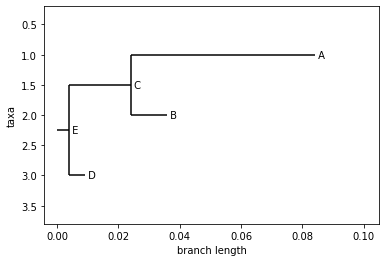

In [15]:
# initialize toy tree with simple topology
mytree = Phylo.read(StringIO("((A:.060,B:.01200)C:.020,D:.0050)E:.004;"), 'newick')
Phylo.draw(mytree)

In [16]:
# arbitrary rate parameter
myrates = [(.5, np.log(1/3)), (1, np.log(1/3)), (1.5, np.log(1/3))]

In [17]:
# randomly generate root sequence
ref_seq = np.ndarray(seq_len, dtype=np.dtype("<U1"))
for i in range(seq_len):
    p = mygtr.Pi[:, i]
    ref_seq[i] = np.random.choice(mygtr.alphabet, p=p)
mytree.root.ref_seq = ref_seq
print ("Root sequence: " + ''.join(mytree.root.ref_seq.astype('U')))

Root sequence: ATTGCGAGCCCATCACGTGCCTCCATCCCGGTAATAAATTGGCATGATACAAGTCATATTATACAAGGATTGGATTCTTAGTGGACTGTCTCTGAATTGTCCGCCAGTGTCGCTCATTCTCCCGGCTCTTAGACGTCTATTTTACGGTACCTATTCATAACATCTTTTGGCTCAAGATGATCTACCTCAAATGATCAAATTCTTTTCACGAGTTAGCCGGCAGGCTATCTTATTGTGCTGTAACCCTTACAAGTCCCATCCTTAAGCTCCGAACACATATTACTGGCGTTTTCATACTCAATCTGAATAGTTGTATCTTGTTCGTCCAGCGCTATGGTACGATCGCTAAAGGAAAACGGCACTAAAGGGTCAAGACCTCATAATTGATCGACTAGAAACG


In [18]:
# simulate evolution from root, store resulting sequences in nodes of mytree as node.ref_seq
mutation_list = defaultdict(list)
for node in mytree.find_clades():
    for c in node.clades:
        c.up = node
    if hasattr(node, 'ref_seq'): # root
        node.ref_mutations = []
        continue
    rand_idx = random.randrange(len(myrates))
    rate_multiplier, _ = myrates[rand_idx]
    t = node.branch_length * rate_multiplier
    p = mygtr.evolve( seq_utils.seq2prof(node.up.ref_seq, mygtr.profile_map), t)
    # normalize profile
    p=(p.T/p.sum(axis=1)).T
    # sample mutations randomly
    ref_seq_idxs = np.array([int(np.random.choice(np.arange(p.shape[1]), p=p[k])) for k in np.arange(p.shape[0])])

    node.ref_seq = np.array([mygtr.alphabet[k] for k in ref_seq_idxs])

    node.ref_mutations = [(anc, pos, der) for pos, (anc, der) in
                        enumerate(zip(node.up.ref_seq, node.ref_seq)) if anc!=der]
    for anc, pos, der in node.ref_mutations:
        mutation_list[pos].append((node.name, anc, der))
    print ("Node", node.name, "mutations:", len(node.ref_mutations), node.ref_mutations)
    print()

Node C mutations: 10 [('A', 0, 'G'), ('T', 12, 'A'), ('C', 20, 'T'), ('A', 84, 'C'), ('C', 85, 'G'), ('A', 159, 'C'), ('T', 279, 'A'), ('G', 330, 'C'), ('C', 359, 'A'), ('G', 399, 'A')]

Node A mutations: 16 [('C', 8, 'G'), ('C', 15, 'A'), ('A', 57, 'T'), ('A', 94, 'C'), ('C', 103, 'G'), ('C', 112, 'G'), ('C', 118, 'T'), ('T', 166, 'C'), ('C', 201, 'T'), ('T', 205, 'C'), ('A', 231, 'C'), ('A', 272, 'C'), ('C', 325, 'T'), ('A', 360, 'T'), ('A', 379, 'G'), ('T', 380, 'A')]

Node B mutations: 1 [('G', 0, 'C')]

Node D mutations: 2 [('T', 232, 'A'), ('C', 370, 'A')]



In [19]:
# set leaf nodes to evolved sequences, and construct an alignment from them
alnstr = ""
i = 1
for leaf in mytree.get_terminals():
    alnstr += ">" + leaf.name + "\n" + ''.join(leaf.ref_seq.astype('U')) + '\n'
    i += 1
myaln = AlignIO.read(StringIO(alnstr), 'fasta')
print(alnstr)

>A
GTTGCGAGGCCAACAAGTGCTTCCATCCCGGTAATAAATTGGCATGATACAAGTCATTTTATACAAGGATTGGATTCTTAGTGGCGTGTCTCTGCATTGTCCGGCAGTGTCGGTCATTTTCCCGGCTCTTAGACGTCTATTTTACGGTACCTATTCATACCATCTTCTGGCTCAAGATGATCTACCTCAAATGATCAAATTTTTTCCACGAGTTAGCCGGCAGGCTATCTTCTTGTGCTGTAACCCTTACAAGTCCCATCCTTAAGCTCCGACCACATAATACTGGCGTTTTCATACTCAATCTGAATAGTTGTATCTTGTTCGTTCAGCCCTATGGTACGATCGCTAAAGGAAAACGGATCTAAAGGGTCAAGACCTCGAAATTGATCGACTAGAAACA
>B
CTTGCGAGCCCAACACGTGCTTCCATCCCGGTAATAAATTGGCATGATACAAGTCATATTATACAAGGATTGGATTCTTAGTGGCGTGTCTCTGAATTGTCCGCCAGTGTCGCTCATTCTCCCGGCTCTTAGACGTCTATTTTACGGTACCTATTCATACCATCTTTTGGCTCAAGATGATCTACCTCAAATGATCAAATTCTTTTCACGAGTTAGCCGGCAGGCTATCTTATTGTGCTGTAACCCTTACAAGTCCCATCCTTAAGCTCCGAACACATAATACTGGCGTTTTCATACTCAATCTGAATAGTTGTATCTTGTTCGTCCAGCCCTATGGTACGATCGCTAAAGGAAAACGGAACTAAAGGGTCAAGACCTCATAATTGATCGACTAGAAACA
>D
ATTGCGAGCCCATCACGTGCCTCCATCCCGGTAATAAATTGGCATGATACAAGTCATATTATACAAGGATTGGATTCTTAGTGGACTGTCTCTGAATTGTCCGCCAGTGTCGCTCATTCTCCCGGCTCTTAGACGTCTATTTTACGGTACCTATTCATAACATCTTTTGGCTCAAGATGATCTACCTCA

In [20]:
# mytree not used in inference, only other params like alignment
anc_tree = TreeAnc(gtr=mygtr, tree=mytree, aln=myaln, rates=myrates, compress=False)


0.00	-TreeAnc: set-up

0.00	-SequenceData: loaded alignment.


In [21]:
anc_tree.infer_ancestral_sequences(marginal=False) # so joint=True


13.30	-TreeAnc.infer_ancestral_sequences with method: probabilistic, joint

13.30	WARNING: Previous versions of TreeTime (<0.7.0) RECONSTRUCTED sequences of
     	tips at positions with AMBIGUOUS bases. This resulted in unexpected
     	behavior is some cases and is no longer done by default. If you want to
     	replace those ambiguous sites with their most likely state, rerun with
     	`reconstruct_tip_states=True` or `--reconstruct-tip-states`.
13.30	--TreeAnc._ml_anc_marginal: type of reconstruction: Marginal


0

In [22]:
diff_count = 0
mut_count = 0
for node in anc_tree.tree.find_clades():
    mut_count += len(node.ref_mutations)
    diff_count += np.sum(node.sequence != node.ref_seq)

print("Number of sites differing from reference (out of 800):", diff_count)
assert diff_count < 10

Number of sites differing from reference (out of 800): 3


In [23]:
print(anc_tree.get_reconstructed_alignment())

70.75	--TreeAnc.get_reconstructed_alignment ...
Alphabet() alignment with 5 rows and 400 columns
ATTGCGAGCCCATCACGTGCCTCCATCCCGGTAATAAATTGGCA...ACG E
ATTGCGAGCCCATCACGTGCCTCCATCCCGGTAATAAATTGGCA...ACG D
CTTGCGAGCCCAACACGTGCTTCCATCCCGGTAATAAATTGGCA...ACA C
GTTGCGAGGCCAACAAGTGCTTCCATCCCGGTAATAAATTGGCA...ACA A
CTTGCGAGCCCAACACGTGCTTCCATCCCGGTAATAAATTGGCA...ACA B
